# Elementary frequency domain filtering

**Author: Uzhva Denis Romanovich**

**Lecturer: Soloviev Igor Pavlovich**

## The basics of filtering in the frequency domain
### Theory

A concept of frequency is very important in the study of signal processing.
Frequency is the number of occurrences of a repeating event per unit of time.
In order to obtain a spectrum (and phases) of a signal, e.g. a set of frequencies, we usually use the discrete fourier transformation.
Since an image has two spatial dimensions, the transformation is also two-dimensional.
The corresponding equation is as follows:
$$
\begin{equation}
F(u, v) = \sum_{x=0}^{H-1} \sum_{y=0}^{W-1} f(x, y) e^{-j2\pi (ux/H + vy/W)},
\tag{1}
\end{equation}
$$
where $f(x, y)$ is a digital image of size $H \times W$.


### Code

#### Discrete fourier transformation

In [223]:
import numpy as np


def get_dft(img, shift=False):
    h = img.shape[0]
    w = img.shape[1]
    img_dft = np.zeros_like(img, dtype=np.complex)
    img = img.astype(np.complex)
    
    x_arr = np.arange(h)
    y_arr = np.arange(w)
    
    x_mat = np.repeat(x_arr.reshape((h, 1)), w, 1)
    y_mat = np.repeat(y_arr.reshape((1, w)), h, 0)
    
    if shift:
        exp_val = (x_mat + y_mat) * np.pi * 1j
        img = np.multiply(img, np.exp(exp_val))
    
    if len(img.shape) == 3:
        channels = img.shape[-1]
        for ch in range(channels):
            for u in range(h):
                for v in range(w):
                    exp_val = -(u * x_mat / h + v * y_mat / w) * np.pi * 2j
                    img_dft[u, v] = np.sum(np.multiply(img[:, :, ch], np.exp(exp_val)))
    else:
         for u in range(h):
            for v in range(w):
                exp_val = (u * x_mat / h + v * y_mat / w) * np.pi * 2j
                img_dft[u, v] = np.sum(np.multiply(img, np.exp(exp_val)))
                
                
    return img_dft

#### Inverse DFT

In [208]:
import numpy as np


def get_idft(img_dft, shift=False):
    h = img_dft.shape[0]
    w = img_dft.shape[1]
    img_idft = np.zeros_like(img_dft, dtype=np.complex)
    img_dft = img_dft.astype(np.complex)
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
     
    if shift:
        exp_val = (u_mat + v_mat) * np.pi * 1j
        img_dft = np.multiply(img_dft, np.exp(exp_val))
        
    if len(img_dft.shape) == 3:
        channels = img_dft.shape[-1]
        for ch in range(channels):
            for x in range(h):
                for y in range(w):
                    exp_val = (x * u_mat / h + y * v_mat / w) * np.pi * 2j
                    img_idft[x, y] = np.sum(np.multiply(img_dft[:, :, ch], np.exp(exp_val)))
    else:
        for x in range(h):
            for y in range(w):
                exp_val = (x * u_mat / h + y * v_mat / w) * np.pi * 2j
                img_idft[x, y] = np.sum(np.multiply(img_dft, np.exp(exp_val)))
    
    img_idft /= (h * w)
                
    return img_idft

### Results

#### Processing + visualization

First of all, we need to load images for the further processing.
We load images with quite simple patterns in order to describe the relations between the frequency and spatial domains.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_1 = Image.open('./pattern1.png')
img_2 = Image.open('./pattern2.png')

In [4]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(64, 64, 3)
(64, 64, 3)


In [5]:
# simplify the images by summing the channels
np_1_sum = np.sum(np_1, axis=2)
np_2_sum = np.sum(np_2, axis=2)

Apply DFT to the images:

In [6]:
np_1_dft = get_dft(np_1_sum)

In [8]:
np_2_dft = get_dft(np_2_sum)

In [13]:
# log of abs

np_1_dft_logabs = np.log(np.abs(np_1_dft))
np_2_dft_logabs = np.log(np.abs(np_2_dft))

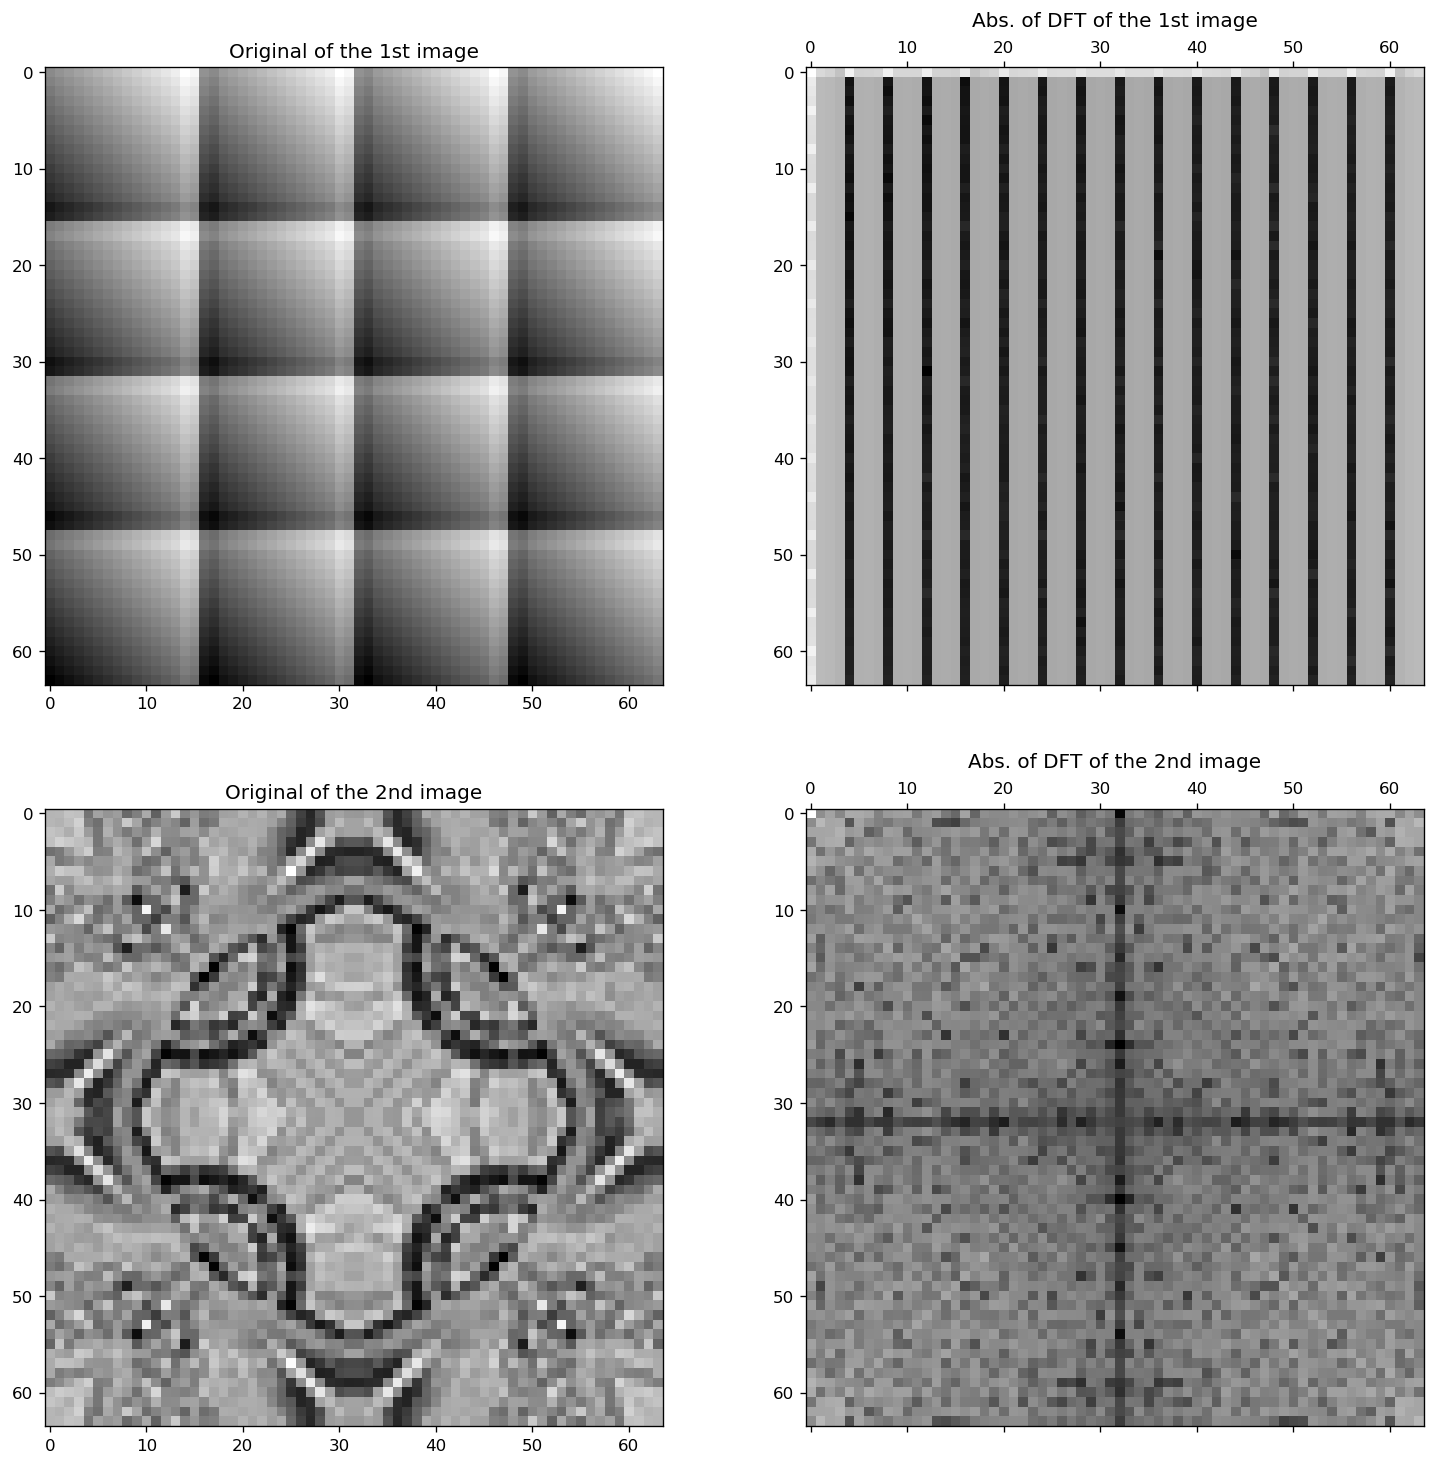

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].matshow(np_1_dft_logabs, cmap='gray')
axs[0, 1].set_title('Abs. of DFT of the 1st image')
axs[1, 0].imshow(np_2_sum, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].matshow(np_2_dft_logabs, cmap='gray')
axs[1, 1].set_title('Abs. of DFT of the 2nd image')
plt.show()

It can be seen that patterns emerge in the frequency domain, which correspond to the repetative nature of the patterns on the original images.
The 1st image is espetially interesting, since the pattern looks like a "sawtooth" signal, so that is depicted on the DFT.

## Simple band-rejection filter
### Theory

The idea is to filter an image in the frequency domain, so that we adjust certain frequencies of an image.
The band-rejection (or band-stop) filter is a very simple filter that nullifies certain frequencies or just makes them very low.
In order to apply such a filter, we use an operation of convolution in the spatial domain, which corresponds to multiplication in the frequency domain:
$$
\begin{equation}
f(x, y) * h(x, y) \iff F(u, v) H(u, v),
\tag{1}
\end{equation}
$$
where $*$ is a convolution, $f(x,y)$ and $F(u, v)$ are an image and its fourier transform, while $h(x, y)$ and $H(u, v)$ stand for a filter and its representation in the frequency domain obtained by DFT.
With that in mind, the simplest band-rejection filter can be defined as follows:
$$
\begin{equation}
H(u, v) = 
\begin{cases}
      0, & \text{if}\ u = H/2, v = W/2 \\
      1, & \text{otherwise}
    \end{cases}
\tag{1}
\end{equation}
$$

### Code

#### Center frequency rejection

In [164]:
import numpy as np


def apply_cr_H(img_dft, size=3):
    h2 = img_dft.shape[0] // 2
    w2 = img_dft.shape[1] // 2
    
    img_dft[h2-size:h2+size+1, w2-size:w2+size+1] = 0.j
    
    return(img_dft)

### Results

#### Processing + visualization

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_21 = Image.open('./int.jpg')
img_22 = Image.open('./flux.jpg')

In [28]:
# represent the images as tensors
np_21 = np.array(img_21)
np_22 = np.array(img_22)
print('Picture dimensions:')
print(np_21.shape)
print(np_22.shape)

Picture dimensions:
(128, 128, 3)
(128, 128, 3)


In [29]:
# simplify the images by summing the channels
np_21_sum = np.sum(np_21, axis=2)
np_22_sum = np.sum(np_22, axis=2)

Apply DFT and filter to the images:

In [209]:
np_21_dft = get_dft(np_21_sum, True)

In [210]:
np_22_dft = get_dft(np_22_sum, True)

In [211]:
np_21_dft_h = apply_cr_H(np_21_dft, 3)
np_22_dft_h = apply_cr_H(np_22_dft, 3)

Obtain IDFT:

In [212]:
np_21_idft = get_idft(np_21_dft_h)

In [213]:
np_22_idft = get_idft(np_22_dft_h)

In [214]:
np_21_idft_abs = np.abs(np_21_idft)
np_22_idft_abs = np.abs(np_22_idft)

In [215]:
np_21_idft_abs /= np.max(np_21_idft_abs)
np_22_idft_abs /= np.max(np_22_idft_abs)

In [216]:
np_21_idft_abs[np_21_idft_abs < 0] = 0.
np_22_idft_abs[np_22_idft_abs < 0] = 0.

In [217]:
np_21_idft_abs = np.rot90(np.rot90(np_21_idft_abs))
np_22_idft_abs = np.rot90(np.rot90(np_22_idft_abs))

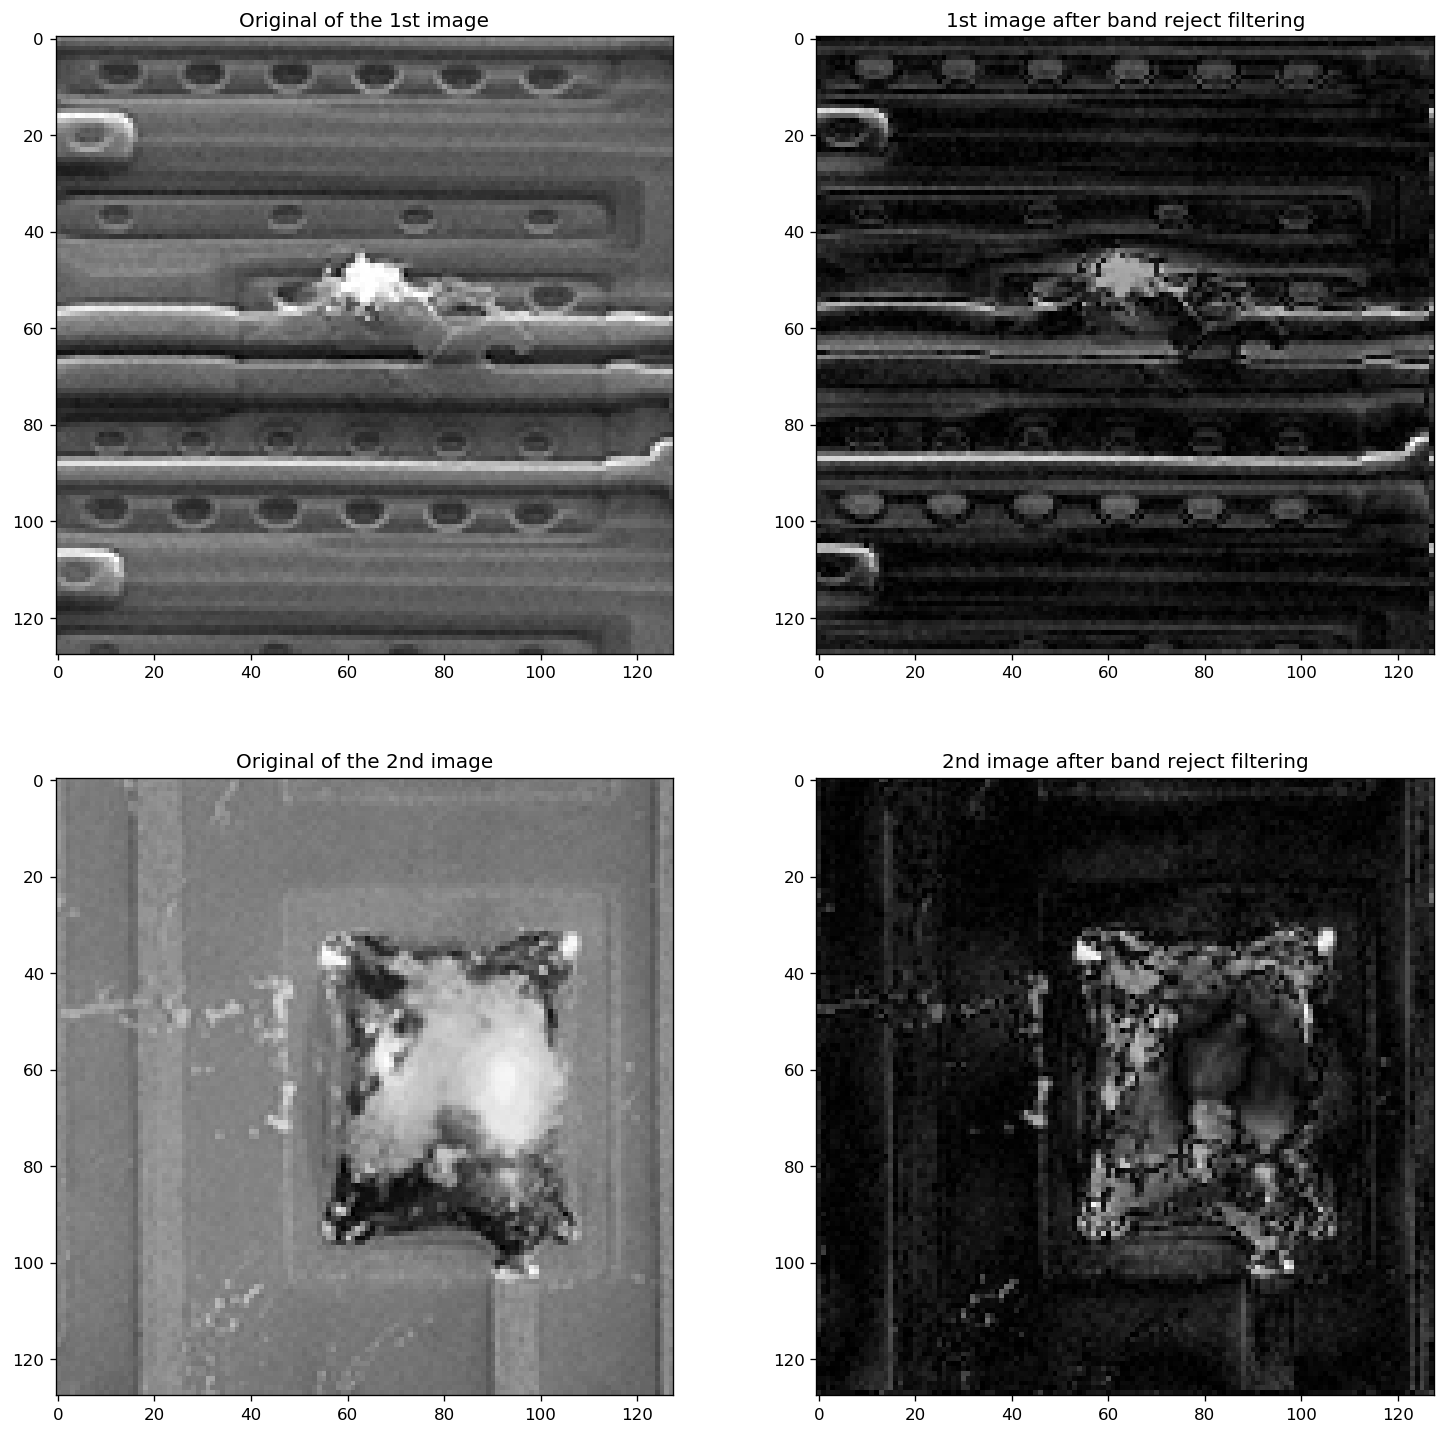

In [222]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_21_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_21_idft_abs, cmap='gray')
axs[0, 1].set_title('1st image after band reject filtering')
axs[1, 0].imshow(np_22_sum, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].imshow(np_22_idft_abs, cmap='gray')
axs[1, 1].set_title('2nd image after band reject filtering')
plt.show()

It is clear that band reject filtering allowed to better recognize the defects on the circuits: it highlighted them by removing low frequencies, so that it is easier to detect anomalies.